In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

sns.set_style("dark")

In [2]:
directory = '2CW100/0925/C2CW100_25-Sep-2016 09_22_05.csv'
col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second']
df = pd.read_csv(directory, header=None, names=col_names)



In [3]:
def get_day_frame(directory, date, remove_zeros=True):
    """
    Returns the day frame for all files in the directory
    date: (month, date, year) tuple, for adding the relevant columns
    """
    files = os.listdir(directory)
    frames = []
    for filename in files:
        path = directory + filename
        frames.append(pd.read_csv(path, header=None, names=col_names))

    # Concatenate readings from all files
    day_frame = pd.concat(frames)
    day_frame['Day'] = date[1]
    day_frame['Month'] = date[0]
    day_frame['Year'] = date[2]
    
    # Light hour is from 9am to 7pm
    day_frame['Light'] = (day_frame.Hour >= 7) & (day_frame.Hour <= 21)
    
    # Remove zeros if specified
    if remove_zeros:
        day_frame = day_frame[(day_frame['x'] != 0) & (day_frame['y'] != 0)]
    
    return day_frame
    

In [4]:
day_frame_0925 = get_day_frame('2CW100/0925/', (9, 25, 2016))
day_frame_0926 = get_day_frame('2CW100/0926/', (9, 26, 2016))
day_frame_0927 = get_day_frame('2CW100/0927/', (9, 27, 2016))
day_frame_0928 = get_day_frame('2CW100/0928/', (9, 28, 2016))
day_frame_0929 = get_day_frame('2CW100/0929/', (9, 29, 2016))
day_frame_0930 = get_day_frame('2CW100/0930/', (9, 30, 2016))




In [5]:
frames = [day_frame_0925, day_frame_0926, day_frame_0927, \
          day_frame_0928, day_frame_0929, day_frame_0930]

frame_2CW100_all = pd.concat(frames)

In [6]:
frame_2CW100_all

,Interval,x,y,Area,Hour,Minute,Second,Day,Month,Year,Light
0,0.044798,223.090,117.430,1345,9,5,0.462,25,9,2016,True
1,0.136530,223.880,117.620,1412,9,5,0.599,25,9,2016,True
2,0.141080,229.030,125.870,1934,9,5,0.740,25,9,2016,True
3,0.063108,224.400,118.160,1422,9,5,0.803,25,9,2016,True
4,0.065758,224.340,117.990,1436,9,5,0.869,25,9,2016,True
5,0.067577,229.540,126.780,1988,9,5,0.937,25,9,2016,True
6,0.065412,229.240,126.830,2024,9,5,1.002,25,9,2016,True
7,0.065407,228.800,127.070,2051,9,5,1.067,25,9,2016,True
8,0.064656,228.710,126.530,2009,9,5,1.132,25,9,2016,True
9,0.064802,226.120,130.190,2545,9,5,1.197,25,9,2016,True


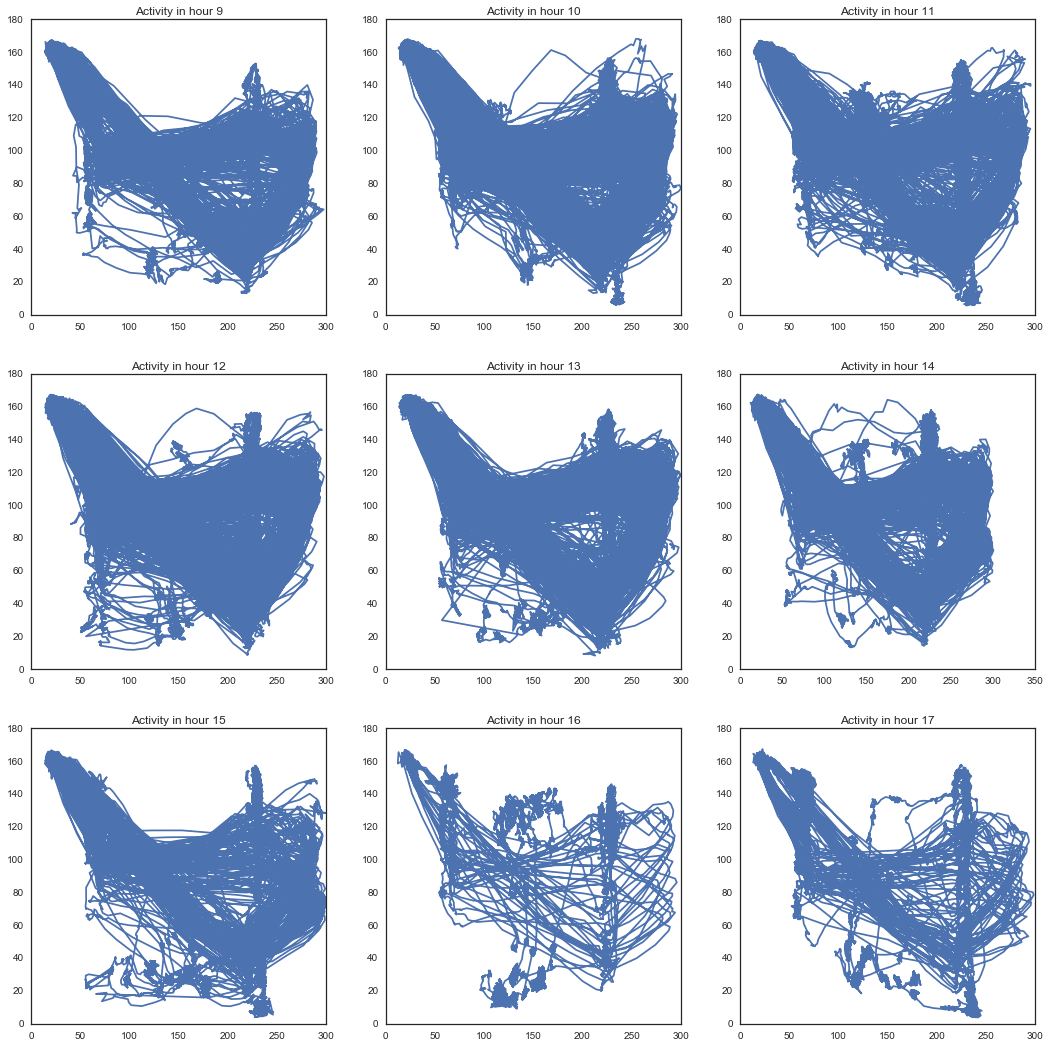

In [7]:
frame_to_display = day_frame_0927

# Visualization of hourly patterns
fig, ax = plt.subplots(3, 3, figsize=(18,18))
ax_pos = [(x,y) for x in range(3) for y in range(3)] # list all positions on the grid

hour = 9
for coord in ax_pos:
    hour_frame = frame_to_display[frame_to_display['Hour'] == hour]
    ax[coord].plot(hour_frame['x'], hour_frame['y'])
    ax[coord].set_title('Activity in hour ' + str(hour))
    
    hour += 1

In [8]:
def get_displacement(day_frame):
    '''
    Get displacement from x and y coords
    '''
    dx = np.diff(day_frame['x'])
    dy = np.diff(day_frame['y'])
    displacement = np.sqrt(dx * dx + dy * dy)
    
    # Diff returns n-1 values, so concatenate a 0 behind and make a new column
    return np.concatenate((displacement, [0])) 

def get_zeit(day_frame, start_time_str=None):
    '''
    Compute the zeitgeber time, starting from 9am, in unit of hours
    '''
    timeseries = pd.to_datetime(day_frame[['Day','Month', 'Year','Hour','Minute','Second']])
    
    if start_time_str == None:
        starttime = timeseries[0]
    else:
        starttime = pd.to_datetime(start_time_str)

    return (timeseries - starttime) / pd.Timedelta(1, unit='h')


In [9]:
frame_2CW100_all['Displacement'] = get_displacement(frame_2CW100_all)
frame_2CW100_all['ZeitTime'] = get_zeit(frame_2CW100_all, start_time_str='9/25/2016 7:00AM')


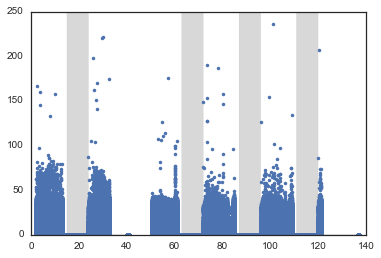

In [10]:
plt.plot(frame_2CW100_all['ZeitTime'], frame_2CW100_all['Displacement'], '.')
plt.fill_between(frame_2CW100_all.ZeitTime, 0, 250, where=~frame_2CW100_all.Light, color='gray',  alpha=0.3)

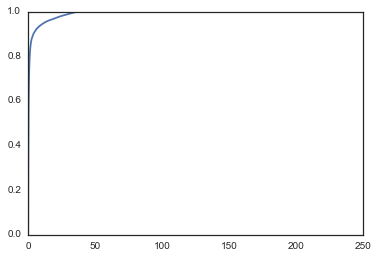

In [12]:
def ecdf(data):
    return np.sort(data), np.arange(len(data)) / float(len(data))

x, y = ecdf(frame_2CW100_all.Displacement)
plt.plot(x, y)

In [18]:
def aggregate_activity(day_frame, time, unit):
    """
    Unit: either 'Hour', 'Minute', or 'Second'
    Returns a data frame which is the total distance travelled in time * unit time specified
    """
    if unit == 'Hour':
        scale = 3600
    elif unit == 'Minute':
        scale = 60
    elif unit == 'Second':
        scale = 1
    else:
        raise ValueError('Invalid time unit')
        
    group_duration = time * scale # Number of seconds to group
    SECS_PER_DAY = 3600 * 24
    
    # ZeitTime is measured in hours, partitioned into groups of
    # specified group_duration
    group = (day_frame['ZeitTime'] / (group_duration/3600.0)).astype('int')
    agg_displacement = day_frame['Displacement'].groupby(group)
    
    agg_sum_grouped = agg_displacement.sum()
    
    # Create data frame with day information
    day = agg_sum_grouped.index / int(SECS_PER_DAY / group_duration)
    time_in_day = agg_sum_grouped.index % int(SECS_PER_DAY / group_duration)
    
    agg_frame_grouped = pd.DataFrame.from_items([('Period', time_in_day), 
                                                 ('Activity', agg_sum_grouped), ('Day', day)])
    
    
    
    return agg_frame_grouped

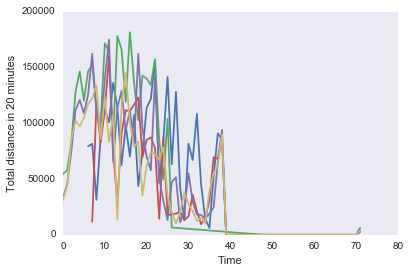

In [24]:
activity = aggregate_activity(frame_2CW100_all, time=20, unit='Minute')
for day in range(5):
    activity_day = activity.Activity[activity.Day == day]
    time_in_day = activity.Period[activity.Day == day]
    plt.plot(time_in_day, activity_day)
plt.xlabel('Time')
plt.ylabel('Total distance in 20 minutes')
